In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import os
import glob
import functools

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg

import pandas as pd
from PIL import Image

import tensorflow as tf
print(tf.__version__)
import tensorflow.contrib as tfcontrib
from tensorflow.python.keras import models
!pip install SimpleITK
import SimpleITK as sitk 
from skimage.transform import resize
from scipy.ndimage import affine_transform

1.13.1
     |████████████████████████████████| 42.5MB 32.3MB/s 


In [4]:
%load_ext autoreload
%autoreload 2
%cd '/content/gdrive/My Drive/DeepLearning/2DUnet-git'

/content/gdrive/My Drive/DeepLearning/2DUnet-git


In [0]:
from tensorflow.python.keras import backend as K

In [0]:
from utils import getTrainNLabelNames
from prediction import data_preprocess_intensity, data_preprocess_scale, data_preprocess_intensity_2scale

In [0]:
def getLayerIndexByName(model, layernames):
    ids = []
    for idx, layer in enumerate(model.layers):
        print(layer.name)
        if layer.name in layernames:
            ids.append(idx)
    return ids

In [0]:
from matplotlib import offsetbox
def plot_embedding(X, y, title=None):
    classes = ["ct", "mr"]
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    plt.figure()
    ax = plt.subplot(111)
    for i in range(len(np.unique(y))):
      X_c = X[y==i,:]
      plt.scatter(X_c[:,0], X_c[:,1],color=plt.cm.tab10(i/ 10.), label=classes[i] )

    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [0]:
from skimage.transform import resize
def croppedImage(img_fn, mask_fn, m, view, size):
  img_vol, _, _ = data_preprocess_intensity_2scale(img_fn, m)
  print(img_vol.shape)
  img_vol = data_preprocess_scale(img_vol, view, 256)
  msk = sitk.ReadImage(mask_fn)
  print(msk.GetSpacing())
  print(msk.GetOrigin())
  print(msk.GetDirection())
  maskVol = sitk.GetArrayFromImage(msk).astype(float)
  space = msk.GetSpacing()
  maskshape = maskVol.shape
  maskVol = resize(maskVol, (space[0]*maskshape[0],space[1]*maskshape[1], space[2]*maskshape[2])) 
  if m == "mr":
    maskVol = np.moveaxis(maskVol, 0, -1)
    
  maskVol = np.moveaxis(maskVol, view, 0)
  IDs = np.max(np.max(maskVol,axis=-1),axis=-1)==0
  sliced = np.moveaxis(img_vol,view,0)[~IDs,:,:]
  sliced = np.moveaxis(resize(sliced, (size,256,256), order=1), 0, view)
  mask_sliced = np.moveaxis(maskVol,view,0)[~IDs,:,:]
  mask_sliced = np.moveaxis(resize(mask_sliced, (size,256,256), order=1), 0, view)
  
  return sliced, mask_sliced

# Visualization for MR and MR + histogram equalization

In [0]:
modality = ["mr"]
data_folder = '/content/gdrive/My Drive/ImageData/MMWHS'
x_train_filenames_mr, y_train_filenames_mr = getTrainNLabelNames(data_folder, modality[0])
print("Number of training volumes %d" % len(x_train_filenames_mr))
print("Number of mask volumes %d" % len(y_train_filenames_mr))

Number of training volumes 20
Number of mask volumes 20


In [0]:
from loss import bce_dice_loss, dice_loss
save_model_path_both = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_eqlhst/weights_multi-all-axial_small2.hdf5'
from model import UNet2D
img_shape = (256, 256, 1)
inputs, outputs = UNet2D(img_shape, 8)
unet = models.Model(inputs=[inputs], outputs=[outputs])
unet.load_weights(save_model_path_both)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
def HistogramEqualization(pyIm):
    pyImNew = np.empty(pyIm.shape)

    num = int(np.max(pyIm.flatten())-np.min(pyIm.flatten()))+1
    im_hist, bins = np.histogram(pyIm.flatten(), num)

    cdf = im_hist.cumsum()
    cdf = max(pyIm.flatten()) * cdf /cdf[-1]

    image_equalized = np.interp(pyIm.flatten(),bins[:-1],cdf)
    pyImNew = np.reshape(image_equalized,pyIm.shape)
    
    return pyImNew

In [0]:
from preProcess import RescaleIntensity
def data_preprocess_intensity(image_vol_fn, m, eqlhst=False):
    img = sitk.ReadImage(image_vol_fn)
    image_vol = sitk.GetArrayFromImage(img).astype(float)
    original_shape = image_vol.shape
    if m =="mr":
        image_vol = np.moveaxis(image_vol,0,-1)
 
    ori = img.GetOrigin()
    space = img.GetSpacing()
    direc = img.GetDirection()
    print(np.min(image_vol), np.max(image_vol))

    image_vol = RescaleIntensity(image_vol, m, [750,-750])
    
    if eqlhst:
        image_vol = HistogramEqualization(image_vol)
        print(np.min(image_vol), np.max(image_vol))
        
    image_vol = RescaleIntensity(image_vol, m, [np.max(image_vol),np.min(image_vol)])
    print(np.min(image_vol), np.max(image_vol))
#     if eqlhst:
#         image_vol = HistogramEqualization(image_vol)
#         print(np.min(image_vol), np.max(image_vol))
    image_info = (ori, space, direc)
    
    return image_vol, original_shape, image_info

In [0]:
from skimage.transform import resize
def croppedImage_eqlhst(img_fn, mask_fn, m, view, size, eqlhst=False):
  img_vol, _, _ = data_preprocess_intensity(img_fn, m, eqlhst)
  print(img_vol.shape)
  img_vol = data_preprocess_scale(img_vol, view, 256)
  msk = sitk.ReadImage(mask_fn)

  maskVol = sitk.GetArrayFromImage(msk).astype(float)
  if m == "mr":
    maskVol = np.moveaxis(maskVol, 0, -1)
    
  maskVol = np.moveaxis(maskVol, view, 0)
  IDs = np.max(np.max(maskVol,axis=-1),axis=-1)==0
  sliced = np.moveaxis(img_vol,view,0)[~IDs,:,:]
  sliced = np.moveaxis(resize(sliced, (size,256,256), order=1), 0, view)
  mask_sliced = np.moveaxis(maskVol,view,0)[~IDs,:,:]
  mask_sliced = np.moveaxis(resize(mask_sliced, (size,256,256), order=1), 0, view)
  
  return sliced, mask_sliced

(512, 512, 160)
(0.78125, 0.78125, 1.600000023841858)
(-206.0869598388672, -155.02609252929688, -199.21875)
(1.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(512, 512, 128)
(0.78125, 0.78125, 1.600000023841858)
(-187.81460571289062, -94.62042999267578, -190.7644500732422)
(1.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(288, 288, 160)
(1.0, 1.0, 1.0499999523162842)
(134.70086669921875, -172.93592834472656, -103.38882446289062)
(-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(288, 288, 120)
(0.9722222089767456, 0.9722222089767456, 1.0499999523162842)
(134.70086669921875, -172.93592834472656, -103.38882446289062)
(-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(288, 288, 130)
(1.0, 1.0, 1.0499999523162842)
(134.70086669921875, -172.93592834472656, -103.38882446289062)
(-0.0, 0.0, -1.0, 1.0, -0.0, 0.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(256, 256, 160)
(1.2109375, 1.2109375, 0.8999999761581421)
(134.70086669921875, -172.9359283447

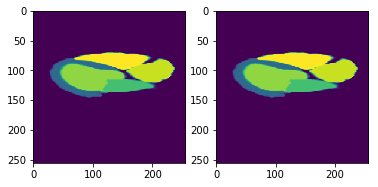

In [0]:
# visualize mask 
num = 20
outputs_mr = []
for i in range(num):
  _, features_ct = croppedImage_eqlhst(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[0], 0, 50, eqlhst=False)
  print(features_ct.shape)
  outputs_mr.append(features_ct.flatten())
outputs_mr = np.array(outputs_mr)
print(outputs_mr.shape)
outputs_mr_eqlhst = []
for i in range(num):
  _, features_mr = croppedImage_eqlhst(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[0], 0, 50, eqlhst=True)
  print(features_mr.shape)
  outputs_mr_eqlhst.append(features_mr.flatten())
outputs_mr_eqlhst = np.array(outputs_mr_eqlhst)
print(outputs_mr_eqlhst.shape)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(features_ct[20,:,:])
plt.subplot(1,2,2)
plt.imshow(features_mr[20,:,:])
plt.show()

Computing t-SNE embedding


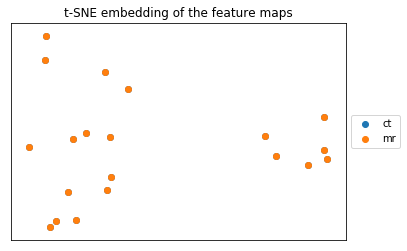

In [0]:
from sklearn import manifold
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.concatenate((outputs_mr, outputs_mr_eqlhst)))

plot_embedding(X_tsne, np.array([np.zeros(num), np.ones(num)]).flatten(),
               "t-SNE embedding of the feature maps")

plt.show()
del outputs_mr_eqlhst
del outputs_mr

In [0]:
#ids = getLayerIndexByName(unet, ["max_pooling2d", "max_pooling2d_1", "max_pooling2d_2","max_pooling2d_3", "max_pooling2d_4", "conv2d_22"])
ids = getLayerIndexByName(unet, ["max_pooling2d_4"])
print(ids)
get_all_layer_outputs = K.function([unet.layers[0].input],
                                  [unet.layers[i].output for i in ids])

input_1
conv2d
batch_normalization_v1
activation
conv2d_1
batch_normalization_v1_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_v1_2
activation_2
conv2d_3
batch_normalization_v1_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_v1_4
activation_4
conv2d_5
batch_normalization_v1_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_v1_6
activation_6
conv2d_7
batch_normalization_v1_7
activation_7
max_pooling2d_3
conv2d_8
batch_normalization_v1_8
activation_8
conv2d_9
batch_normalization_v1_9
activation_9
max_pooling2d_4
conv2d_10
batch_normalization_v1_10
activation_10
conv2d_11
batch_normalization_v1_11
activation_11
conv2d_transpose
concatenate
batch_normalization_v1_12
activation_12
conv2d_12
batch_normalization_v1_13
activation_13
conv2d_13
batch_normalization_v1_14
activation_14
conv2d_transpose_1
concatenate_1
batch_normalization_v1_15
activation_15
conv2d_14
batch_normalization_v1_16
activation_16
conv2d_15
batch_normalization_v1_17
activation_17
conv2d_t

In [0]:
num = 6
outputs_mr = []
for i in range(num):
  features, mask = croppedImage_eqlhst(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[0], 0, 40, eqlhst=False)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features, axis=-1)])
  print(layer_output[0].shape)
  outputs_mr.append(layer_output[0].flatten())
outputs_mr = np.array(outputs_mr).reshape(num*layer_output[0].shape[0], np.prod(layer_output[0].shape[1:]))
print(outputs_mr.shape)
outputs_mr_eqlhst = []
for i in range(num):
  features_eqlhst, mask_eqlhst = croppedImage_eqlhst(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[0], 0, 40, eqlhst=True)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features_eqlhst, axis=-1)])
  print(layer_output[0].shape)
  outputs_mr_eqlhst.append(layer_output[0].flatten())
outputs_mr_eqlhst = np.array(outputs_mr_eqlhst).reshape(num*layer_output[0].shape[0], np.prod(layer_output[0].shape[1:]))
print(outputs_mr_eqlhst.shape)

0.0 4095.0
-1.0 1.0
(512, 512, 160)
(40, 256, 256)
(40, 8, 8, 512)
0.0 4095.0
-1.0 1.0
(512, 512, 128)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1705.0
-1.0 1.0
(288, 288, 160)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1510.0
-1.0 1.0
(288, 288, 120)
(40, 256, 256)
(40, 8, 8, 512)
0.0 2057.0
-1.0 1.0
(288, 288, 130)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1343.0
-1.0 1.0
(256, 256, 160)
(40, 256, 256)
(40, 8, 8, 512)
(240, 32768)
0.0 4095.0
0.8878987073898316 1.0
-0.999999999999999 0.999999999999999
(512, 512, 160)
(40, 256, 256)
(40, 8, 8, 512)
0.0 4095.0
0.7802835404872894 1.0
-1.0 1.0
(512, 512, 128)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1705.0
0.8980550130208333 1.0
-1.0 1.0
(288, 288, 160)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1510.0
0.9587760014789095 1.0
-1.0 1.0
(288, 288, 120)
(40, 256, 256)
(40, 8, 8, 512)
0.0 2057.0
0.9132809717770656 1.0
-1.0 1.0
(288, 288, 130)
(40, 256, 256)
(40, 8, 8, 512)
0.0 1343.0
0.7727088629404704 0.7906666666666666
-1.0 1.0
(256, 256, 160)
(40, 256, 256)
(40, 8, 8, 512)
(2

(10, 40, 256, 256)
(10, 40, 256, 256)


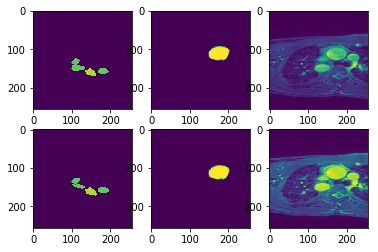

In [0]:
pred_mr = np.argmax(outputs_mr.reshape(num, *layer_output[0].shape), axis=-1)
print(pred_mr.shape)
pred_mr_eqlhst = np.argmax(outputs_mr_eqlhst.reshape(num, *layer_output[0].shape), axis=-1)
print(pred_mr_eqlhst.shape)
slc = 30
plt.figure()
plt.subplot(2,3,1)
plt.imshow(pred_mr[0,slc,:,:], vmin=0, vmax=8)
plt.subplot(2,3,2)
plt.imshow(mask[slc,:,:])
plt.subplot(2,3,3)
plt.imshow(features[slc,:,:])
plt.subplot(2,3,4)
plt.imshow(pred_mr_eqlhst[0,slc,:,:], vmin=0, vmax=8)
plt.subplot(2,3,5)
plt.imshow(mask_eqlhst[slc,:,:])
plt.subplot(2,3,6)
plt.imshow(features_eqlhst[slc,:,:])
plt.show()

In [0]:
from sklearn import manifold
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.concatenate((outputs_mr, outputs_mr_eqlhst)))



Computing t-SNE embedding


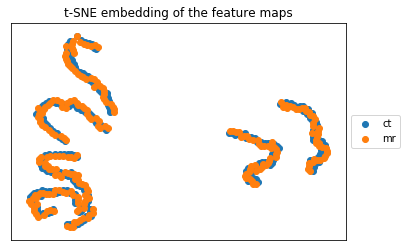

In [0]:
plot_embedding(X_tsne, np.array([np.zeros(num*layer_output[0].shape[0]), np.ones(num*layer_output[0].shape[0])]).flatten(),
               "t-SNE embedding of the feature maps")

plt.show()
del outputs_mr_eqlhst
del outputs_mr

# Visualization for CT and MR

In [9]:
modality = ["ct", "mr"]
data_folder = '/content/gdrive/My Drive/ImageData/MMWHS'
x_train_filenames_ct, y_train_filenames_ct = getTrainNLabelNames(data_folder, modality[0])
print("Number of training volumes %d" % len(x_train_filenames_ct))
print("Number of mask volumes %d" % len(y_train_filenames_ct))
x_train_filenames_mr, y_train_filenames_mr = getTrainNLabelNames(data_folder, modality[1])
print("Number of training volumes %d" % len(x_train_filenames_mr))
print("Number of mask volumes %d" % len(y_train_filenames_mr))

Number of training volumes 20
Number of mask volumes 20
Number of training volumes 20
Number of mask volumes 20


## Compare DNN activation

In [0]:
from loss import bce_dice_loss, dice_loss
save_model_path_both = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_small3/weights_multi-all-axial_small2.hdf5'
save_model_path_ct = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_ct/weights_multi-all-axial_small2.hdf5'
save_model_path_mr = '/content/gdrive/My Drive/DeepLearning/2DUNet/Logs_2/MMWHS_mr/weights_multi-all-axial_small2.hdf5'
from model import UNet2D
img_shape = (256, 256, 1)
inputs, outputs = UNet2D(img_shape, 8)
unet = models.Model(inputs=[inputs], outputs=[outputs])
unet.load_weights(save_model_path_both)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
#ids = getLayerIndexByName(unet, ["max_pooling2d_5", "max_pooling2d_6", "max_pooling2d_7","max_pooling2d_8", "max_pooling2d_9", "conv2d_45"])
ids = getLayerIndexByName(unet, ["conv2d_22"])
print(ids)
get_all_layer_outputs = K.function([unet.layers[0].input],
                                  [unet.layers[i].output for i in ids])

input_1
conv2d
batch_normalization_v1
activation
conv2d_1
batch_normalization_v1_1
activation_1
max_pooling2d
conv2d_2
batch_normalization_v1_2
activation_2
conv2d_3
batch_normalization_v1_3
activation_3
max_pooling2d_1
conv2d_4
batch_normalization_v1_4
activation_4
conv2d_5
batch_normalization_v1_5
activation_5
max_pooling2d_2
conv2d_6
batch_normalization_v1_6
activation_6
conv2d_7
batch_normalization_v1_7
activation_7
max_pooling2d_3
conv2d_8
batch_normalization_v1_8
activation_8
conv2d_9
batch_normalization_v1_9
activation_9
max_pooling2d_4
conv2d_10
batch_normalization_v1_10
activation_10
conv2d_11
batch_normalization_v1_11
activation_11
conv2d_transpose
concatenate
batch_normalization_v1_12
activation_12
conv2d_12
batch_normalization_v1_13
activation_13
conv2d_13
batch_normalization_v1_14
activation_14
conv2d_transpose_1
concatenate_1
batch_normalization_v1_15
activation_15
conv2d_14
batch_normalization_v1_16
activation_16
conv2d_15
batch_normalization_v1_17
activation_17
conv2d_t

In [0]:
num = 6
outputs_ct = []
for i in range(num):
  features,_ = croppedImage(x_train_filenames_ct[i], y_train_filenames_ct[i], modality[0], 0, 40)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features, axis=-1)])
  print(layer_output[0].shape)
  outputs_ct.append(layer_output[0].flatten())
outputs_ct = np.array(outputs_ct).reshape(num*layer_output[0].shape[0], np.prod(layer_output[0].shape[1:]))
print(outputs_ct.shape)
outputs_mr = []
for i in range(num):
  print(x_train_filenames_mr[i], y_train_filenames_mr[i])
  features,_ = croppedImage(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[1], 0, 40)
  print(features.shape)
  layer_output = get_all_layer_outputs([np.expand_dims(features, axis=-1)])
  print(layer_output[0].shape)
  outputs_mr.append(layer_output[0].flatten())
outputs_mr = np.array(outputs_mr).reshape(num*layer_output[0].shape[0], np.prod(layer_output[0].shape[1:]))
print(outputs_mr.shape)

(130, 182, 231)
(0.35546875, 0.35546875, 0.44999998807907104)
(-45.5, 228.58453369140625, -271.8800048828125)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(40, 256, 256)
(40, 256, 256, 8)
(117, 250, 320)
(0.4882810115814209, 0.4882810115814209, 0.625)
(-103.30000305175781, 133.8115997314453, -241.0)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(40, 256, 256)
(40, 256, 256, 8)
(91, 155, 231)
(0.302734375, 0.302734375, 0.44999998807907104)
(-58.900001525878906, 225.9972686767578, -260.3800048828125)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(40, 256, 256)
(40, 256, 256, 8)
(65, 164, 320)
(0.3203119933605194, 0.3203119933605194, 0.625)
(-52.0, 95.17942810058594, -195.875)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(40, 256, 256)
(40, 256, 256, 8)
(87, 250, 320)
(0.4882810115814209, 0.4882810115814209, 0.625)
(-95.0, 87.21159362792969, -188.5)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(40, 256, 256)
(40, 256, 256, 8)
(122, 250, 320)
(0.4882810115814209, 0.4882810115814209

In [0]:
from sklearn import manifold
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(np.concatenate((outputs_ct, outputs_mr)))


Computing t-SNE embedding


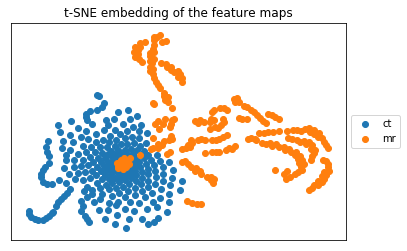

In [0]:

plot_embedding(X_tsne, np.array([np.zeros(num*layer_output[0].shape[0]), np.ones(num*layer_output[0].shape[0])]).flatten(),
               "t-SNE embedding of the feature maps")

plt.show()

In [0]:
# mask 
num = 1
outputs_ct = []
for i in range(num):
  _, features_ct = croppedImage(x_train_filenames_ct[i], y_train_filenames_ct[i], modality[0], 0, 50)
  print(features_ct.shape)
  outputs_ct.append(features_ct.flatten())
outputs_ct = np.array(outputs_ct)
print(outputs_ct.shape)
outputs_mr = []
for i in range(num):
  _, features_mr = croppedImage(x_train_filenames_mr[i], y_train_filenames_mr[i], modality[1], 0, 50)
  print(features_mr.shape)
  outputs_mr.append(features_mr.flatten())
outputs_mr = np.array(outputs_mr)
print(outputs_mr.shape)

(130, 182, 231)
(0.35546875, 0.35546875, 0.44999998807907104)
(-45.5, 228.58453369140625, -271.8800048828125)
(1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
(50, 256, 256)
(1, 3276800)
(400, 820, 125)
(0.78125, 0.78125, 1.600000023841858)
(-206.0869598388672, -155.02609252929688, -199.21875)
(1.0, 0.0, 0.0, 0.0, -0.0, 1.0, 0.0, 1.0, -0.0)
(50, 256, 256)
(1, 3276800)


## Common feature space of MR and CT 

In [0]:
def transform_func(image, reference_image, transform, order=1):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    if order ==1:
      print("Linear")
      interpolator = sitk.sitkLinear
    elif order == 0:
      print("NN")
      interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    try:
      resampled = sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)
    except Exception as e: print(e)
      
    return resampled

In [0]:
def reference_image(spacing, size, dim):
 
  reference_size = [256] * dim
  reference_spacing = [int(np.max(size))/256*spacing] * dim
  #reference_size = size
  reference_image = sitk.Image(reference_size, 0)
  reference_image.SetOrigin(np.zeros(3))
  reference_image.SetSpacing(reference_spacing)
  reference_image.SetDirection(np.eye(3).ravel())
  return reference_image

In [0]:
def centering(img, ref_img, order=1):
  dimension = img.GetDimension()
  transform = sitk.AffineTransform(dimension)
  transform.SetMatrix(img.GetDirection())
  transform.SetTranslation(np.array(img.GetOrigin()) - ref_img.GetOrigin())
  # Modify the transformation to align the centers of the original and reference image instead of their origins.
  centering_transform = sitk.TranslationTransform(dimension)
  img_center = np.array(img.TransformContinuousIndexToPhysicalPoint(np.array(img.GetSize())/2.0))
  reference_center = np.array(ref_img.TransformContinuousIndexToPhysicalPoint(np.array(ref_img.GetSize())/2.0))
  centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
  centered_transform = sitk.Transform(transform)
  centered_transform.AddTransform(centering_transform)

  return transform_func(img, ref_img, centered_transform, order)

In [0]:
def isometric_transform(image, ref_img, orig_direction, order=1):
  # transform image volume to orientation of eye(dim)
  dim = ref_img.GetDimension()
  affine = sitk.AffineTransform(dim)
  target = np.eye(dim)
  
  ori = np.reshape(orig_direction, np.eye(dim).shape)
  affine.SetMatrix(np.matmul(target,np.linalg.inv(ori)).ravel())
  affine.SetCenter(ref_img.TransformContinuousIndexToPhysicalPoint(np.array(ref_img.GetSize())/2.0))
  #affine.SetMatrix(image.GetDirection())
  return transform_func(image, ref_img, affine, order)

In [0]:
def resample_spacing(sitkIm_fn, resolution=0.5, dim=3, order=1):
  image = sitk.ReadImage(sitkIm_fn)
  orig_direction = image.GetDirection()
  orig_size = np.array(image.GetSize(), dtype=np.int)
  orig_spacing = np.array(image.GetSpacing())
  new_size = orig_size*(orig_spacing/np.array(resolution))
  new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
  new_size = [int(s) for s in new_size]
  
  ref_img = reference_image(resolution, new_size, dim)
  centered = centering(image, ref_img, order)
  transformed = isometric_transform(centered, ref_img, orig_direction, order)
  
#   writer = sitk.ImageFileWriter()
#   writer.SetFileName("/content/gdrive/My Drive/DeepLearning/2DUnet-git/1.nii.gz")
#   writer.Execute(centered)
#   writer.SetFileName("/content/gdrive/My Drive/DeepLearning/2DUnet-git/2.nii.gz")
#   writer.Execute(transformed)
  
#   plt.figure()
#   plt.subplot(1,3,1)
#   plt.imshow(sitk.GetArrayFromImage(image)[:,150,:])
#   plt.subplot(1,3,2)
#   plt.imshow(sitk.GetArrayFromImage(centered)[:,150,:])
#   plt.subplot(1,3,3)
#   plt.imshow(sitk.GetArrayFromImage(transformed)[:,150,:])
#   plt.show()
  return transformed, ref_img

In [0]:
# resample images to have resolution 0.5*0.5*0.5
def resample(sitkIm_fn, resolution = (0.5, 0.5, 0.5), dim=3):
  image = sitk.ReadImage(sitkIm_fn)
  resample = sitk.ResampleImageFilter()
  resample.SetInterpolator(sitk.sitkLinear)
  resample.SetOutputDirection(image.GetDirection())
  resample.SetOutputOrigin(image.GetOrigin())
  resample.SetOutputSpacing(resolution)
  print(image.GetDirection())

  orig_size = np.array(image.GetSize(), dtype=np.int)
  orig_spacing = np.array(image.GetSpacing())
  new_size = orig_size*(orig_spacing/np.array(resolution))
  new_size = np.ceil(new_size).astype(np.int) #  Image dimensions are in integers
  new_size = [int(s) for s in new_size]
  resample.SetSize(new_size)
  newimage = resample.Execute(image)
  
  transformed = isometric_transform(newimage)
# #   writer = sitk.ImageFileWriter()
# #   writer.SetFileName("/content/gdrive/My Drive/DeepLearning/2DUnet-git/1.nii.gz")
# #   writer.Execute(newimage)
# #   writer.SetFileName("/content/gdrive/My Drive/DeepLearning/2DUnet-git/2.nii.gz")
# #   writer.Execute(transformed)

# #   resample.SetTransform(transform)
#   #print(newimage.GetDirection())
  
#   plt.figure()
#   plt.subplot(1,2,1)
#   plt.imshow(sitk.GetArrayFromImage(newimage)[:,200,:])
#   plt.subplot(1,2,2)
#   plt.imshow(sitk.GetArrayFromImage(transformed)[:,200,:])
#   plt.show()
  
  return transformed

In [0]:
def resample_scale(sitkIm, ref_img, scale_factor=1., order=1):
  assert type(scale_factor)==np.float64, "Isotropic scaling"
  dim = sitkIm.GetDimension()
  affine = sitk.AffineTransform(dim)
  scale = np.eye(dim)
  np.fill_diagonal(scale, 1./scale_factor)
  
  affine.SetMatrix(scale.ravel())
  affine.SetCenter(sitkIm.TransformContinuousIndexToPhysicalPoint(np.array(sitkIm.GetSize())/2.0))
  transformed = transform_func(sitkIm, ref_img, affine, order)
  plt.figure()
  plt.subplot(1,2,1)
  im = sitk.GetArrayFromImage(sitkIm)
  plt.imshow(im[:,int(im.shape[1]/2),:])
  plt.subplot(1,2,2)
  im = sitk.GetArrayFromImage(transformed)
  plt.imshow(im[:,int(im.shape[1]/2),:])
  plt.show()
  print("ok")
  return transformed
    

In [0]:
from skimage.transform import resize
def cropMask(mask, percentage):
  ori_shape = mask.shape
  print("Original shape before cropping: ", ori_shape)
  # crop the surroundings by percentage
  def boolCounter(boolArr):
    #Count consecutive occurences of values varying in length in a numpy array
    out = np.diff(np.where(np.concatenate(([boolArr[0]],
                                     boolArr[:-1] != boolArr[1:],
                                     [True])))[0])[::2]
    return out
  
  dim  = len(mask.shape)
  for i in range(dim):
    tmp = np.moveaxis(mask, i, 0)
    IDs = np.max(np.max(tmp,axis=-1),axis=-1)==0
    blank = boolCounter(IDs)
    try:
      upper = int(blank[0]*percentage) if int(blank[0]*percentage) != 0 else 1
    except:
      upper = 1
    try:
      lower = -1*int(blank[-1]*percentage) if int(blank[-1]*percentage) !=0 else -1
    except:
      lower = -1
    mask = np.moveaxis(tmp[upper:lower,:,:],0,i)
    
  print("Final shape post cropping: ", mask.shape)
  ratio = np.array(mask.shape)/np.array(ori_shape)
  return mask, ratio

In [0]:
def blankSpaces(y_train_filenames_ct, y_train_filenames_mr):
  num = 20
  ratio_mr = []
  ratio_ct = []
  for i in range(num):
    mask_ct, ratio = cropMask(sitk.GetArrayFromImage(resample_spacing(y_train_filenames_ct[i])[0]),1.)
    print(ratio)
    ratio_ct = np.concatenate((ratio_ct, ratio))
    mask_mr, ratio = cropMask(sitk.GetArrayFromImage(resample_spacing(y_train_filenames_mr[i])[0]),1.)
    print(ratio)
    ratio_mr = np.concatenate((ratio_mr, ratio))
  return ratio_ct, ratio_mr



In [18]:
ratio_ct, ratio_mr = blankSpaces(y_train_filenames_ct, y_train_filenames_mr)
ratio_ct = ratio_ct.reshape(int(len(ratio_ct)/3),3)
ratio_mr = ratio_mr.reshape(int(len(ratio_mr)/3),3)
dim = 3
range_adjust = [None]*dim
for i in range(dim):
  range_adjust[i] = [np.min([np.min(ratio_ct[:,i]), np.min(ratio_mr[:,i])]), np.max([np.max(ratio_ct[:,i]), np.max(ratio_mr[:,i])])]
print(range_adjust)

Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (183, 182, 204)
[0.71484375 0.7109375  0.796875  ]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (91, 76, 95)
[0.35546875 0.296875   0.37109375]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (120, 110, 116)
[0.46875   0.4296875 0.453125 ]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (97, 120, 109)
[0.37890625 0.46875    0.42578125]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (189, 169, 204)
[0.73828125 0.66015625 0.796875  ]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (187, 80, 133)
[0.73046875 0.3125     0.51953125]
Linear
Linear
Original shape before cropping:  (256, 256, 256)
Final shape post cropping:  (178, 154, 177)
[0.6953125  0.6015625  0.69140625]
Linear
Linear


In [0]:
def sample_in_range(range_):
  return (range_[1] - range_[0]) * np.random.random_sample() + range_[0]

[0.59021407 0.71428571 0.8021978 ]
0.8362603943005498


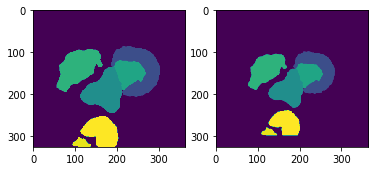

ok
(327, 364, 364)
1.5377109700374867


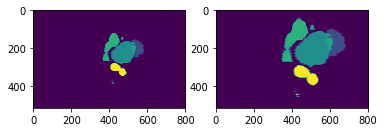

ok
(513, 800, 800)
[0.59021407 0.71428571 0.8021978 ]
0.8844265607037972


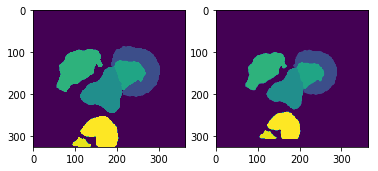

ok
(327, 364, 364)
1.5121421031188191


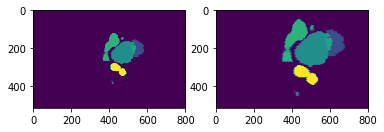

ok
(513, 800, 800)
[0.57190635 0.384      0.452     ]
1.4831558507294738


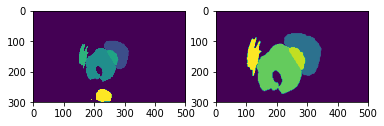

ok
(299, 500, 500)
1.0483042565711873


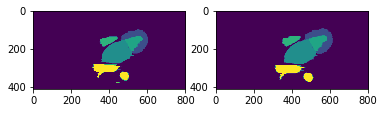

ok
(410, 800, 800)
[0.57190635 0.384      0.452     ]
1.2678967304157787


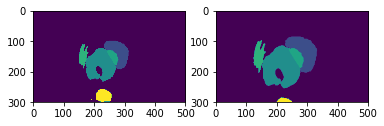

ok
(299, 500, 500)
1.3066630898067044


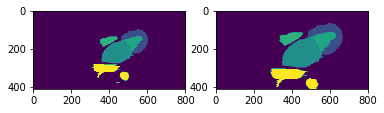

ok
(410, 800, 800)
[0.69516729 0.66451613 0.8       ]
1.0274269882437999


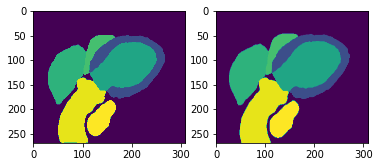

ok
(269, 310, 310)
0.9169944374759879


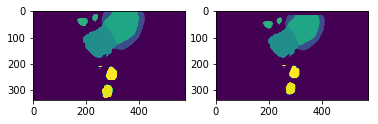

ok
(336, 576, 576)
[0.69516729 0.66451613 0.8       ]
0.8127379627260544


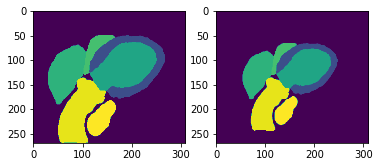

ok
(269, 310, 310)
1.2205399838843054


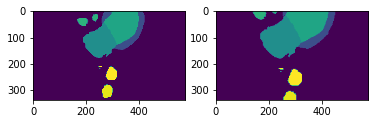

ok
(336, 576, 576)
[0.824      0.58536585 0.69512195]
1.015407823751069


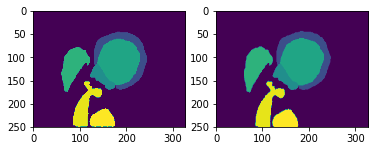

ok
(250, 328, 328)
1.034643525626109


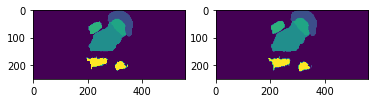

ok
(252, 560, 560)
[0.824      0.58536585 0.69512195]
0.8768964742943467


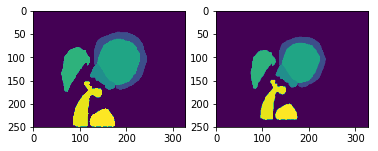

ok
(250, 328, 328)
1.215495656940373


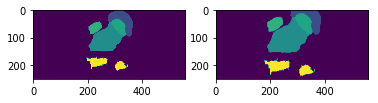

ok
(252, 560, 560)
[0.95945946 0.552      0.618     ]
0.9159496725404664


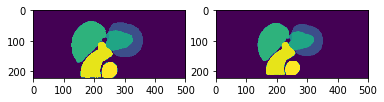

ok
(222, 500, 500)
1.0637706610374664


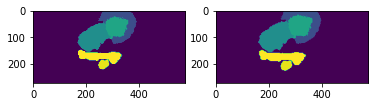

ok
(273, 576, 576)
[0.95945946 0.552      0.618     ]
0.7409229134831948


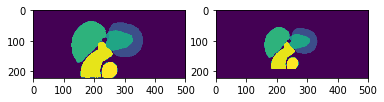

ok
(222, 500, 500)
1.4275515413461488


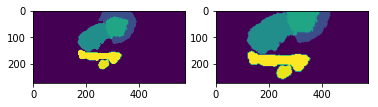

ok
(273, 576, 576)
[0.80645161 0.48       0.552     ]
0.9065400254779147


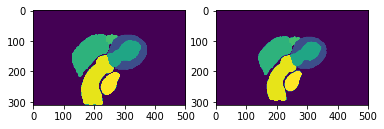

ok
(310, 500, 500)
1.0582703905671422


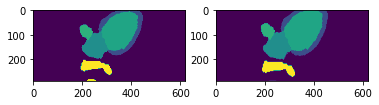

ok
(288, 620, 620)
[0.80645161 0.48       0.552     ]
1.1705290038092653


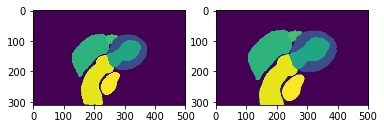

ok
(310, 500, 500)
1.1717438642965856


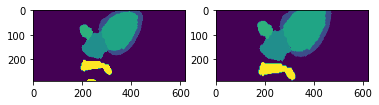

ok
(288, 620, 620)
[0.33552632 0.54138702 0.65995526]
1.1321383707474655


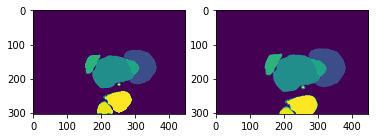

ok
(304, 447, 447)
0.8088073365503039


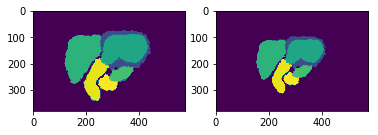

ok
(378, 576, 576)
[0.33552632 0.54138702 0.65995526]
1.4174603671541899


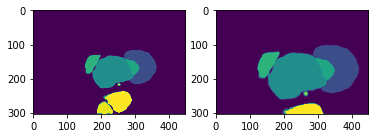

ok
(304, 447, 447)
1.0990238122888651


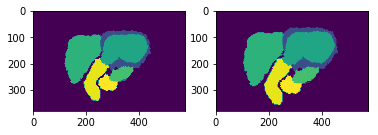

ok
(378, 576, 576)
[0.46043165 0.5625     0.56696429]
1.3301062068602147


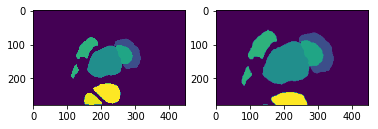

ok
(278, 448, 448)
1.2614833553053204


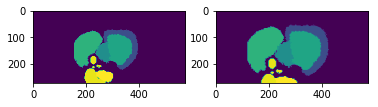

ok
(273, 576, 576)
[0.46043165 0.5625     0.56696429]
0.8851096205639476


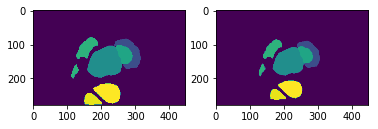

ok
(278, 448, 448)
1.0100281936935953


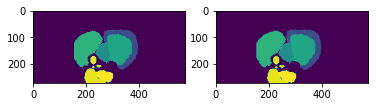

ok
(273, 576, 576)
[0.77384196 0.534      0.544     ]
1.0273718043804791


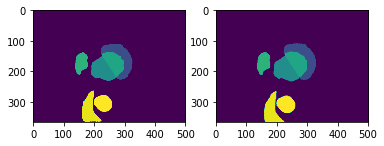

ok
(367, 500, 500)
1.6977922826222163
<built-in function Resample> returned a result with an error set


UnboundLocalError: ignored

In [48]:
# mask 
num = 20
outputs_ct = []
outputs_mr = []
for i in range(num):
  for j in range(2):
    scale_factor = np.mean([sample_in_range(range_adjust[0]), sample_in_range(range_adjust[1]), sample_in_range(range_adjust[2])]/ratio_ct[i,:])
    print(ratio_ct[i,:])
    print(scale_factor)
    sitkIm, ref_img = resample_spacing(y_train_filenames_ct[i])
    mask_ct = sitk.GetArrayFromImage(resample_scale(sitkIm, ref_img, scale_factor))
    print(mask_ct.shape)
    outputs_ct.append(resize(mask_ct,(64,64,64),order=0).flatten())
   
    scale_factor = np.mean([sample_in_range(range_adjust[0]), sample_in_range(range_adjust[1]), sample_in_range(range_adjust[2])]/ratio_mr[i,:])
    print(scale_factor)
    sitkIm, ref_img = resample_spacing(y_train_filenames_mr[i])
    mask_mr = sitk.GetArrayFromImage(resample_scale(sitkIm, ref_img, scale_factor))
    print(mask_mr.shape)
    outputs_mr.append(resize(mask_mr,(64,64,64),order=0).flatten())

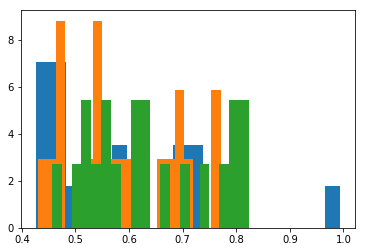

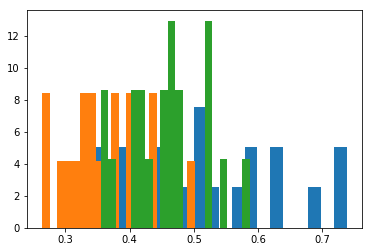

In [0]:
plt.figure()
count, bins, ignored = plt.hist(ratio_ct[:,0], 20, density=True)
count, bins, ignored = plt.hist(ratio_ct[:,1], 20, density=True)
count, bins, ignored = plt.hist(ratio_ct[:,2], 20, density=True)
plt.show()
plt.figure()
count, bins, ignored = plt.hist(ratio_mr[:,0], 20, density=True)
count, bins, ignored = plt.hist(ratio_mr[:,1], 20, density=True)
count, bins, ignored = plt.hist(ratio_mr[:,2], 20, density=True)
plt.show()

NN
NN
NN


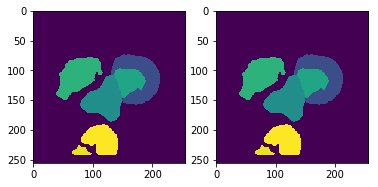

ok
NN
NN
NN


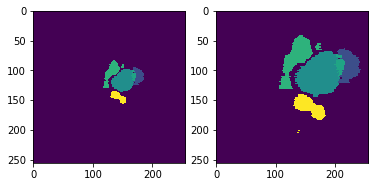

ok
NN
NN
NN


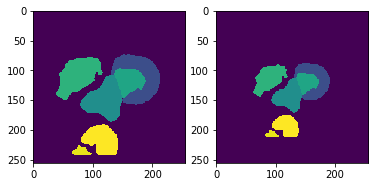

ok
NN
NN
NN


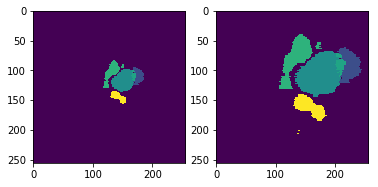

ok
NN
NN
NN


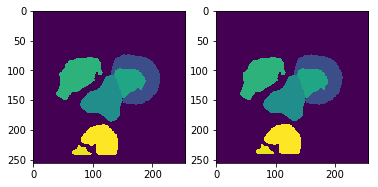

ok
NN
NN
NN


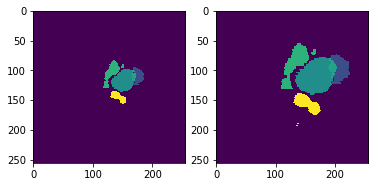

ok
NN
NN
NN


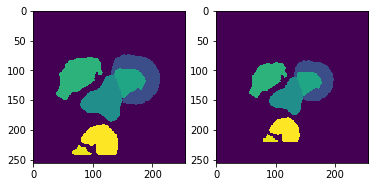

ok
NN
NN
NN


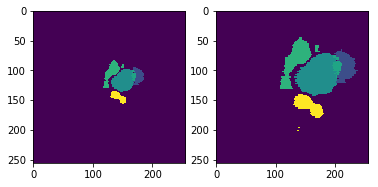

ok
NN
NN
NN


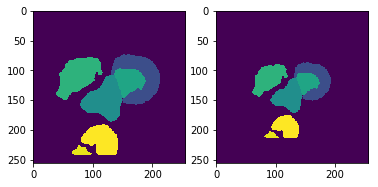

ok
NN
NN
NN


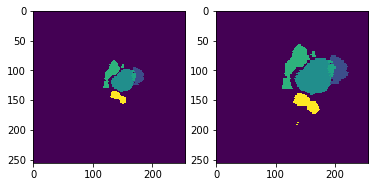

ok
NN
NN
NN


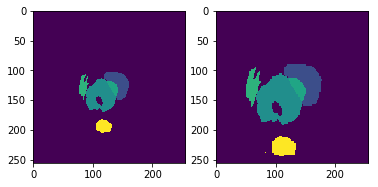

ok
NN
NN
NN


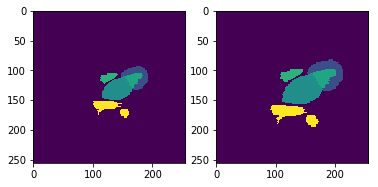

ok
NN
NN
NN


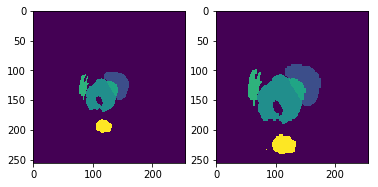

ok
NN
NN
NN


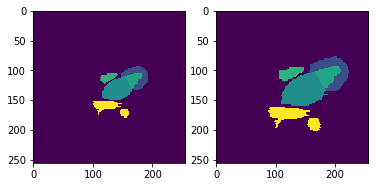

ok
NN
NN
NN


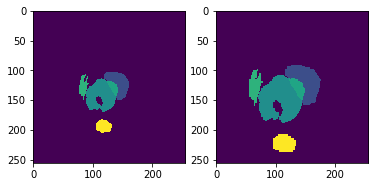

ok
NN
NN
NN


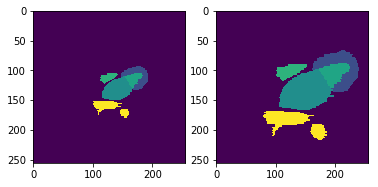

ok
NN
NN
NN


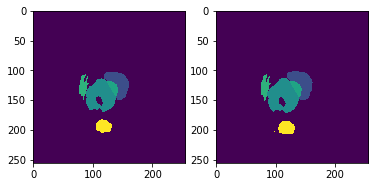

ok
NN
NN
NN


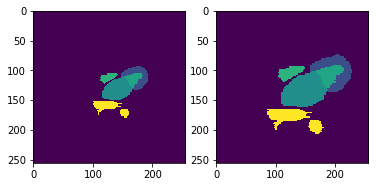

ok
NN
NN
NN


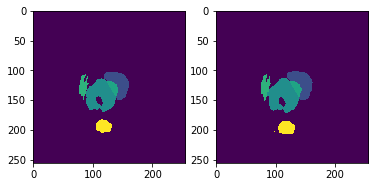

ok
NN
NN
NN


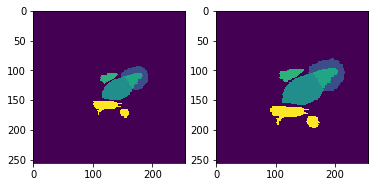

ok
NN
NN
NN


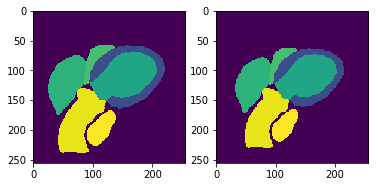

ok
NN
NN
NN


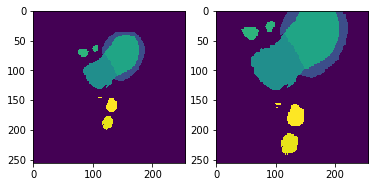

ok
NN
NN
NN


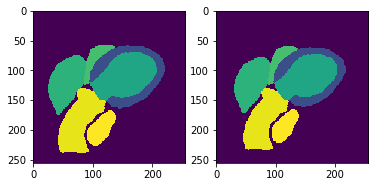

ok
NN
NN
NN


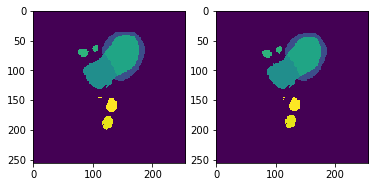

ok
NN
NN
NN


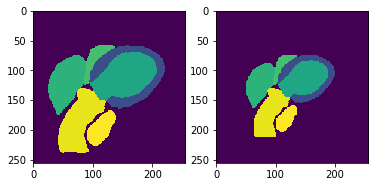

ok
NN
NN
NN


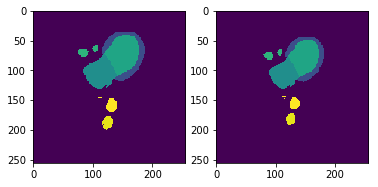

ok
NN
NN
NN


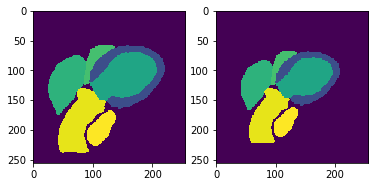

ok
NN
NN
NN


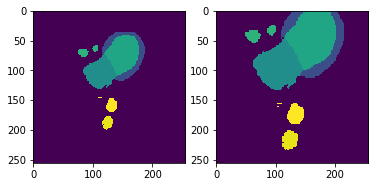

ok
NN
NN
NN


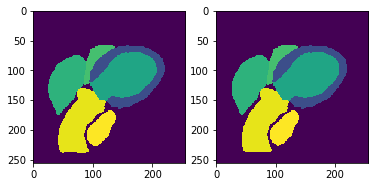

ok
NN
NN
NN


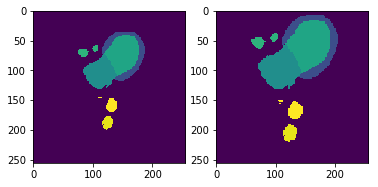

ok
NN
NN
NN


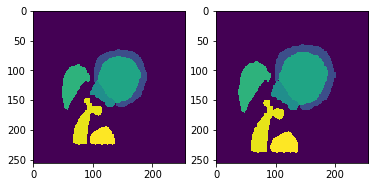

ok
NN
NN
NN


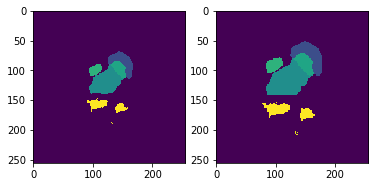

ok
NN
NN
NN


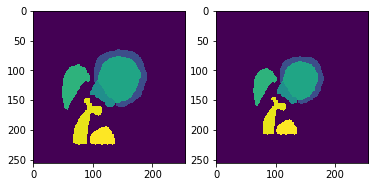

ok
NN
NN
NN


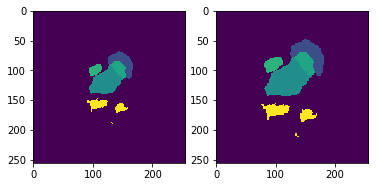

ok
NN
NN
NN


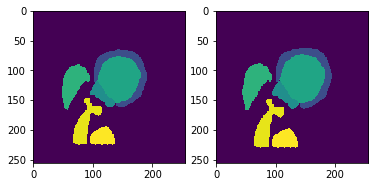

ok
NN
NN
NN


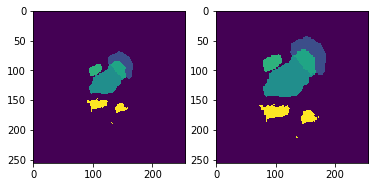

ok
NN
NN
NN


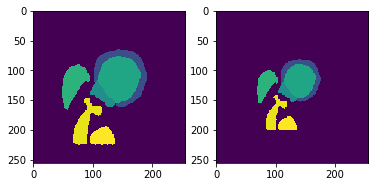

ok
NN
NN
NN


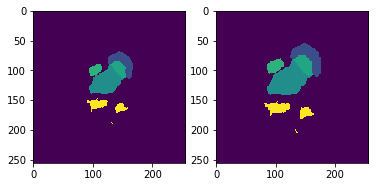

ok
NN
NN
NN


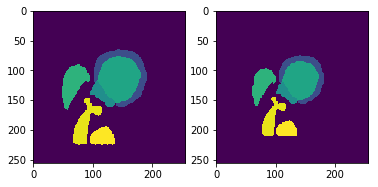

ok
NN
NN
NN


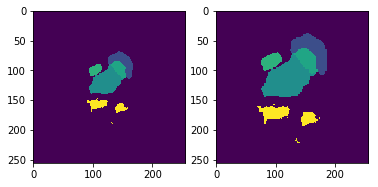

ok
NN
NN
NN


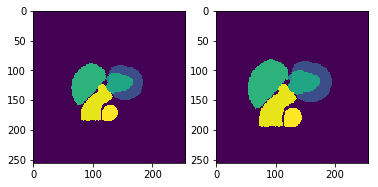

ok
NN
NN
NN


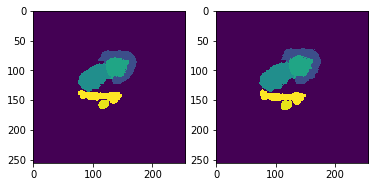

ok
NN
NN
NN


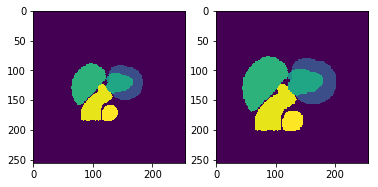

ok
NN
NN
NN


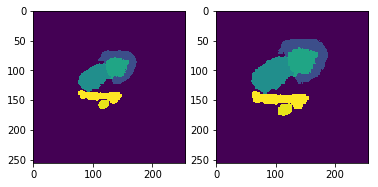

ok
NN
NN
NN


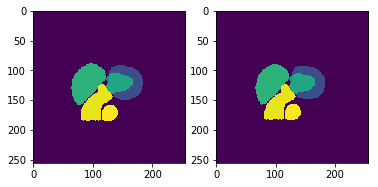

ok
NN
NN
NN


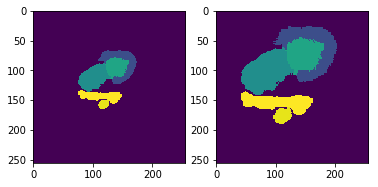

ok
NN
NN
NN


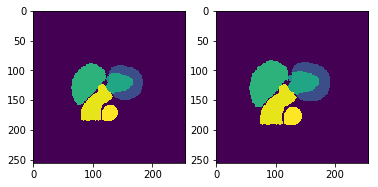

ok
NN
NN
NN


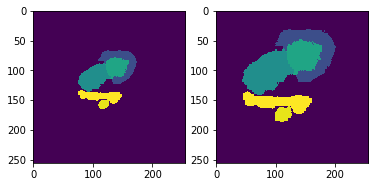

ok
NN
NN
NN


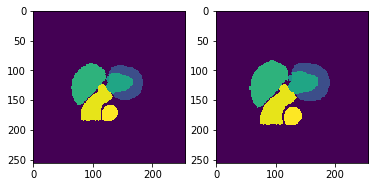

ok
NN
NN
NN


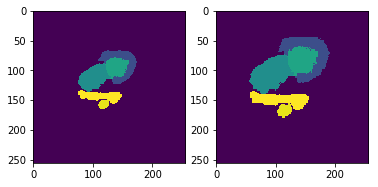

ok
NN
NN
NN


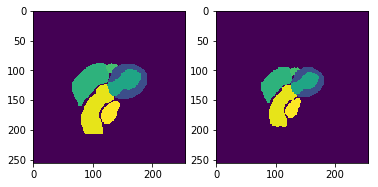

ok
NN
NN
NN


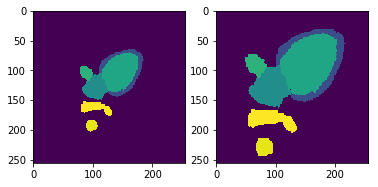

ok
NN
NN
NN


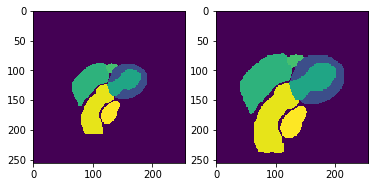

ok
NN
NN
NN


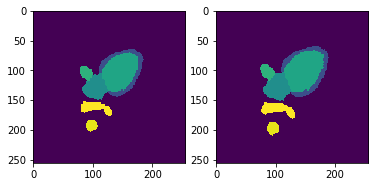

ok
NN
NN
NN


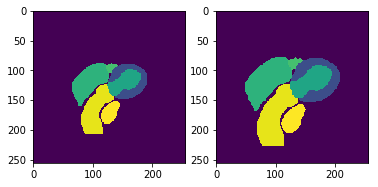

ok
NN
NN
NN


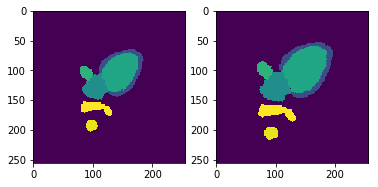

ok
NN
NN
NN


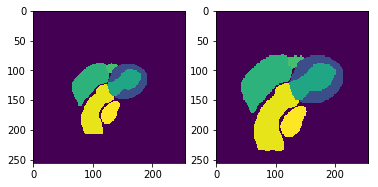

ok
NN
NN
NN


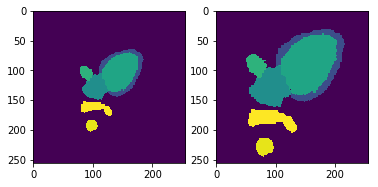

ok
NN
NN
NN


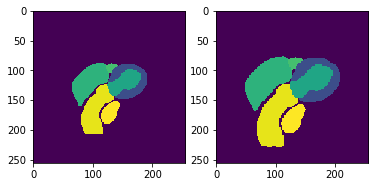

ok
NN
NN
NN


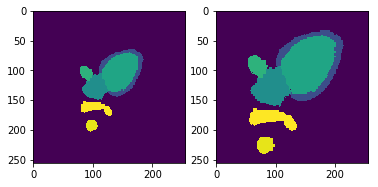

ok
NN
NN
NN


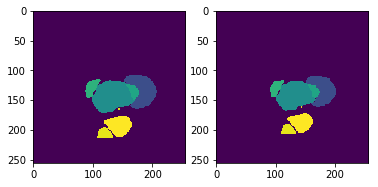

ok
NN
NN
NN


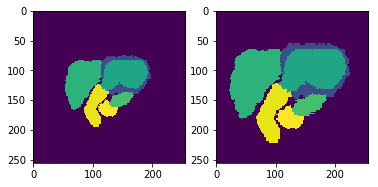

ok
NN
NN
NN


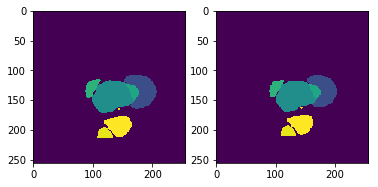

ok
NN
NN
NN


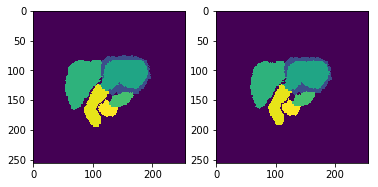

ok
NN
NN
NN


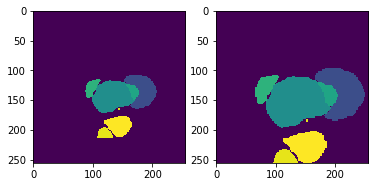

ok
NN
NN
NN


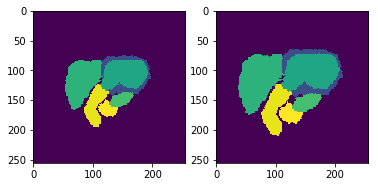

ok
NN
NN
NN


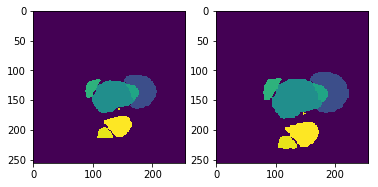

ok
NN
NN
NN


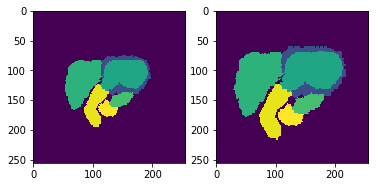

ok
NN
NN
NN


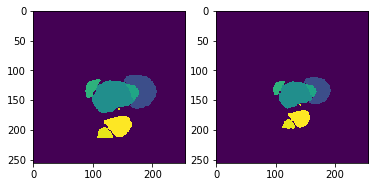

ok
NN
NN
NN


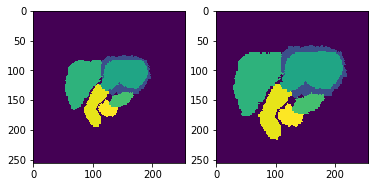

ok
NN
NN
NN


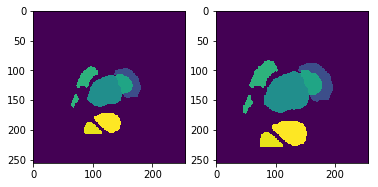

ok
NN
NN
NN


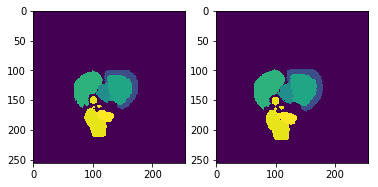

ok
NN
NN
NN


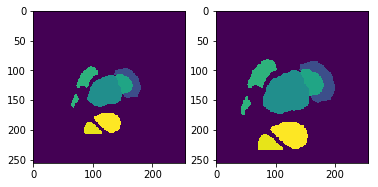

ok
NN
NN
NN


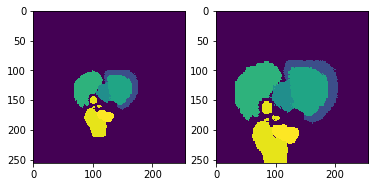

ok
NN
NN
NN


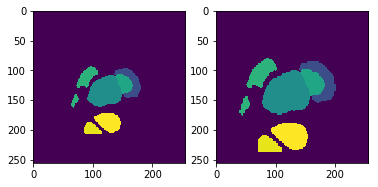

ok
NN
NN
NN


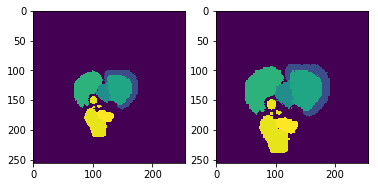

ok
NN
NN
NN


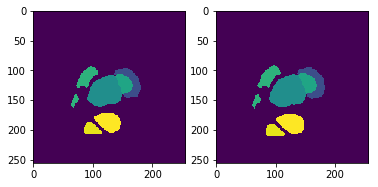

ok
NN
NN
NN


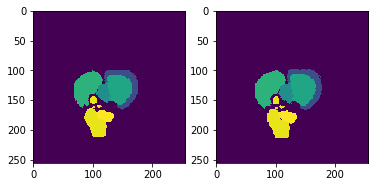

ok
NN
NN
NN


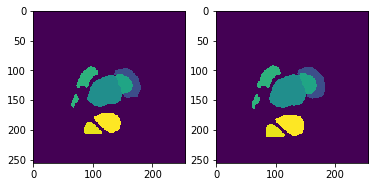

ok
NN
NN
NN


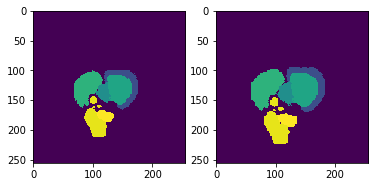

ok
NN
NN
NN


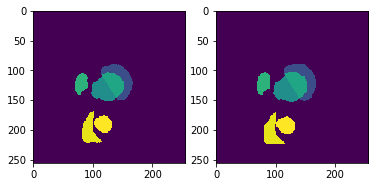

ok
NN
NN
NN


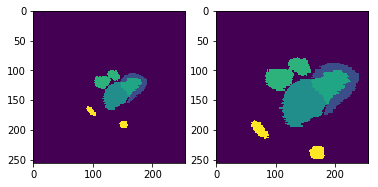

ok
NN
NN
NN


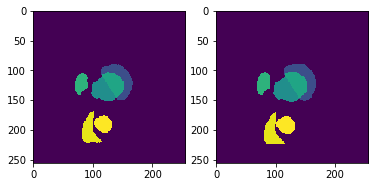

ok
NN
NN
NN


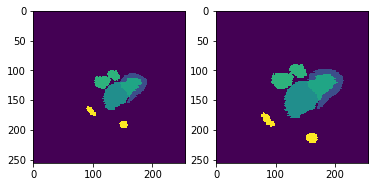

ok
NN
NN
NN


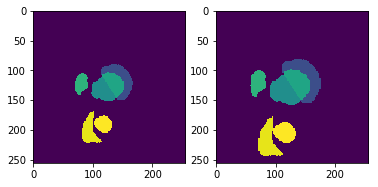

ok
NN
NN
NN


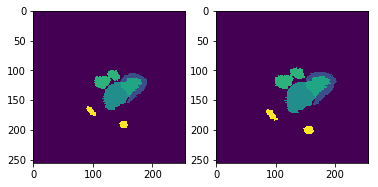

ok
NN
NN
NN


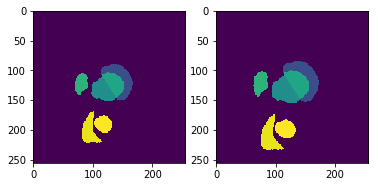

ok
NN
NN
NN


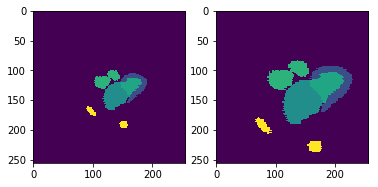

ok
NN
NN
NN


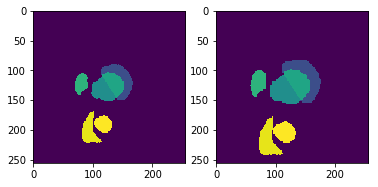

ok
NN
NN
NN


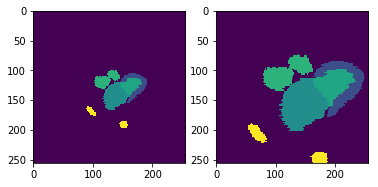

ok
NN
NN
NN


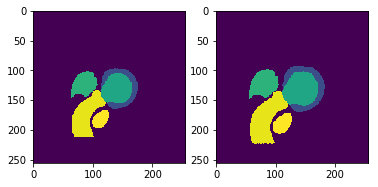

ok
NN
NN
NN


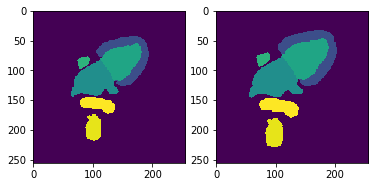

ok
NN
NN
NN


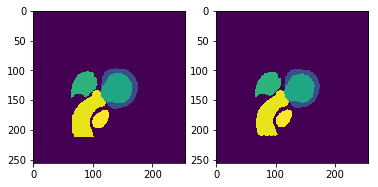

ok
NN
NN
NN


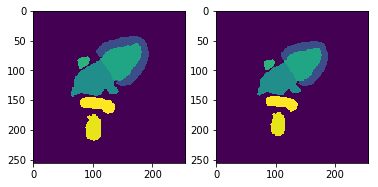

ok
NN
NN
NN


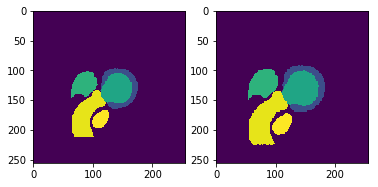

ok
NN
NN
NN


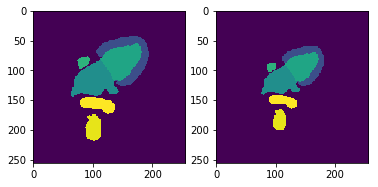

ok
NN
NN
NN


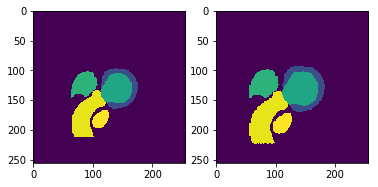

ok
NN
NN
NN


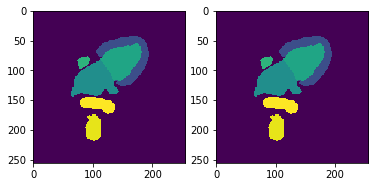

ok
NN
NN
NN


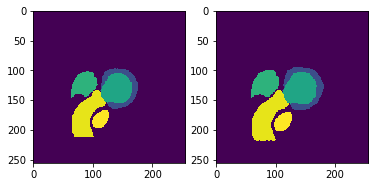

ok
NN
NN
NN


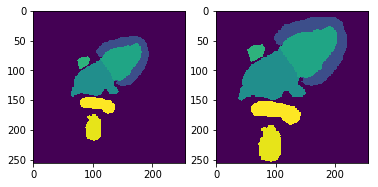

ok
NN
NN
NN


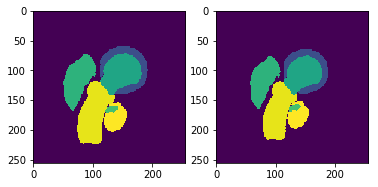

ok
NN
NN
NN


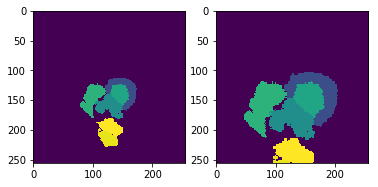

ok
NN
NN
NN


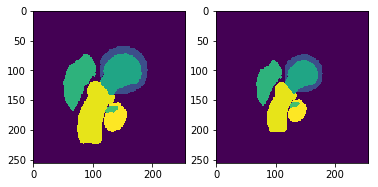

ok
NN
NN
NN


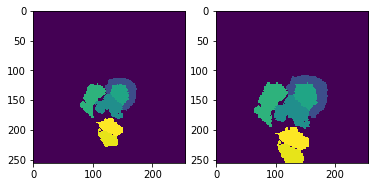

ok
NN
NN
NN


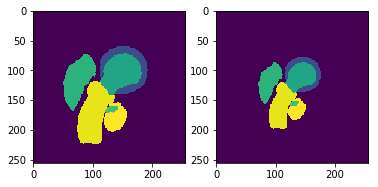

ok
NN
NN
NN


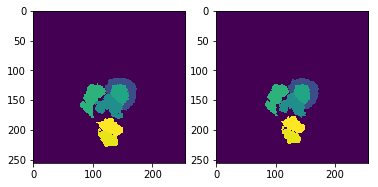

ok
NN
NN
NN


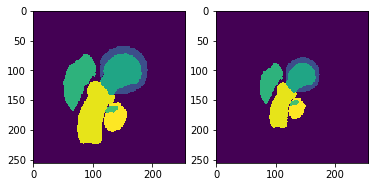

ok
NN
NN
NN


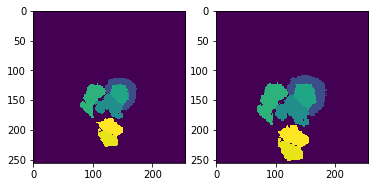

ok
NN
NN
NN


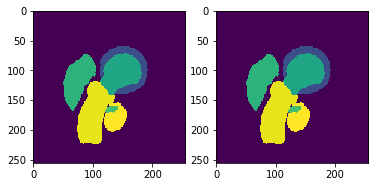

ok
NN
NN
NN


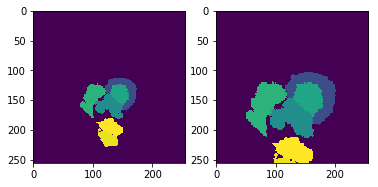

ok
NN
NN
NN


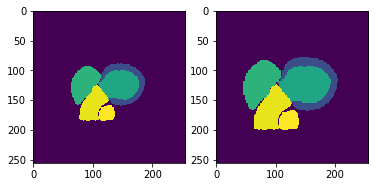

ok
NN
NN
NN


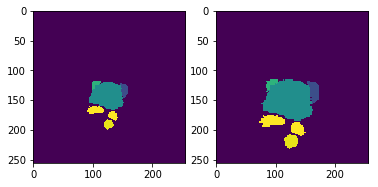

ok
NN
NN
NN


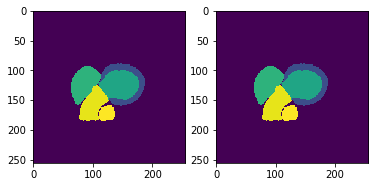

ok
NN
NN
NN


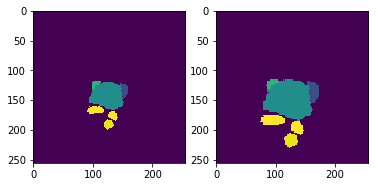

ok
NN
NN
NN


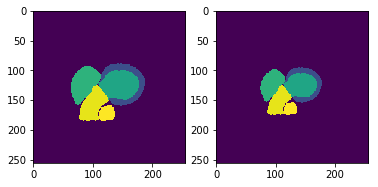

ok
NN
NN
NN


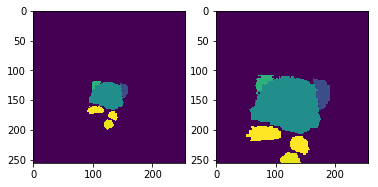

ok
NN
NN
NN


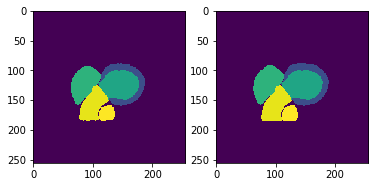

ok
NN
NN
NN


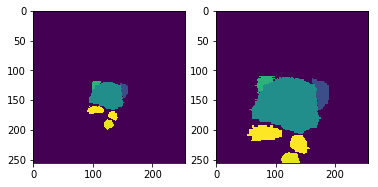

ok
NN
NN
NN


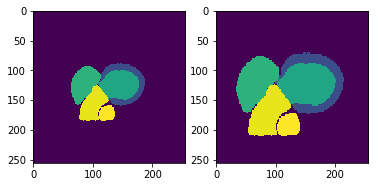

ok
NN
NN
NN


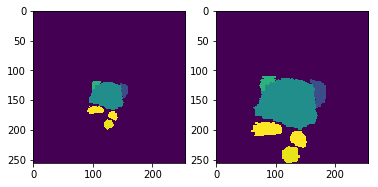

ok
NN
NN
NN


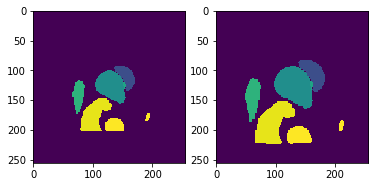

ok
NN
NN
NN


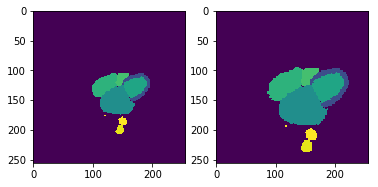

ok
NN
NN
NN


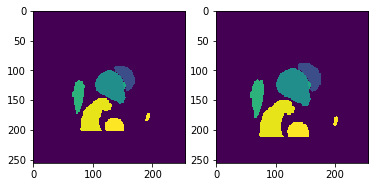

ok
NN
NN
NN


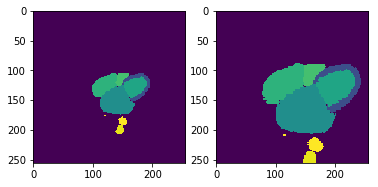

ok
NN
NN
NN


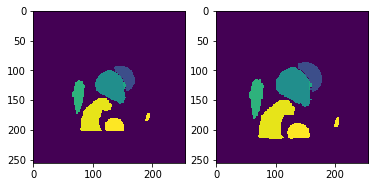

ok
NN
NN
NN


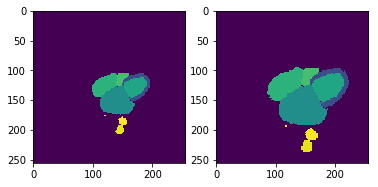

ok
NN
NN
NN


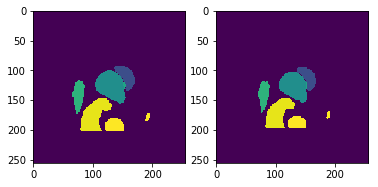

ok
NN
NN
NN


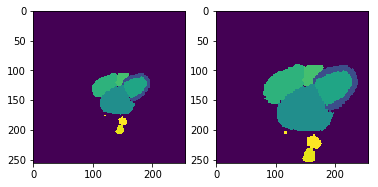

ok
NN
NN
NN


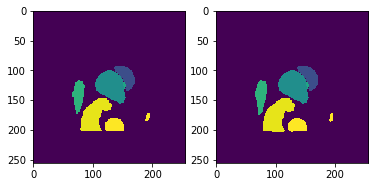

ok
NN
NN
NN


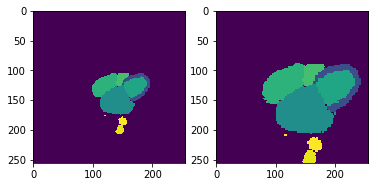

ok
NN
NN
NN


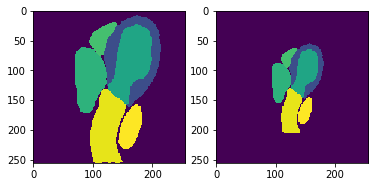

ok
NN
NN
NN


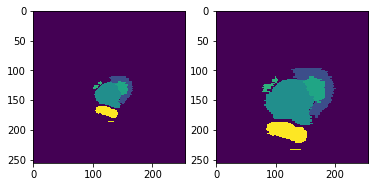

ok
NN
NN
NN


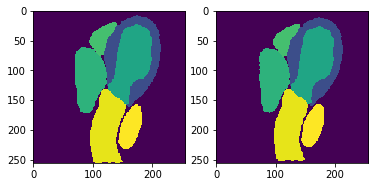

ok
NN
NN
NN


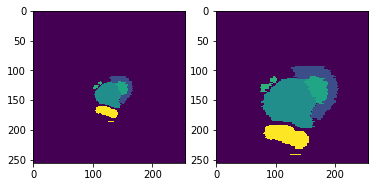

ok
NN
NN
NN


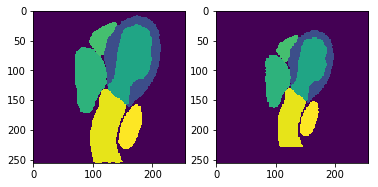

ok
NN
NN
NN


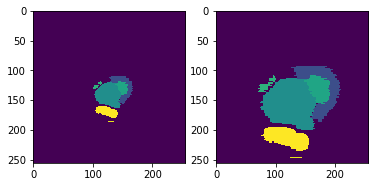

ok
NN
NN
NN


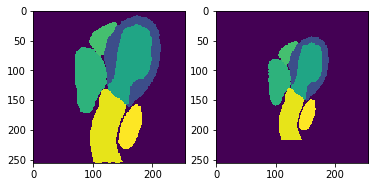

ok
NN
NN
NN


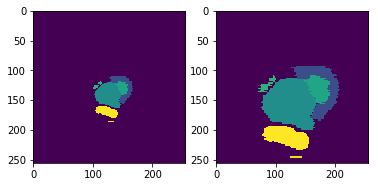

ok
NN
NN
NN


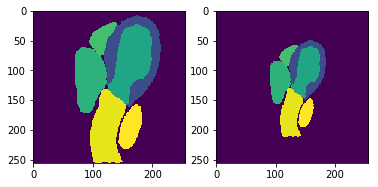

ok
NN
NN
NN


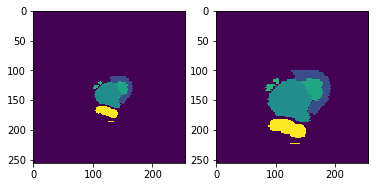

ok
NN
NN
NN


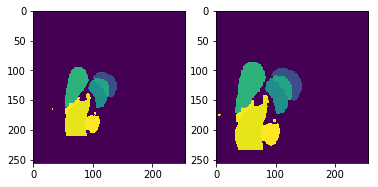

ok
NN
NN
NN


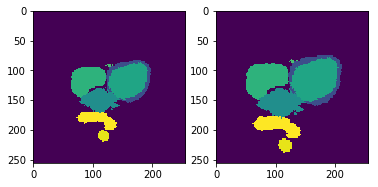

ok
NN
NN
NN


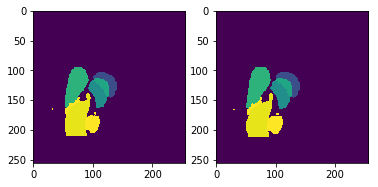

ok
NN
NN
NN


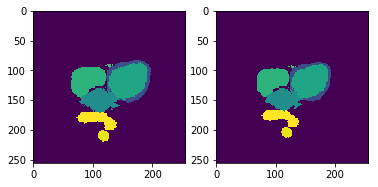

ok
NN
NN
NN


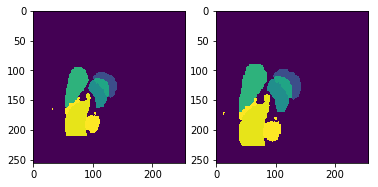

ok
NN
NN
NN


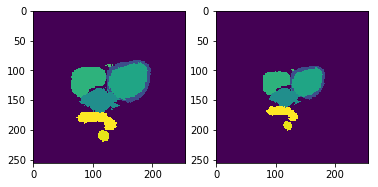

ok
NN
NN
NN


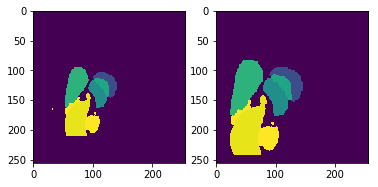

ok
NN
NN
NN


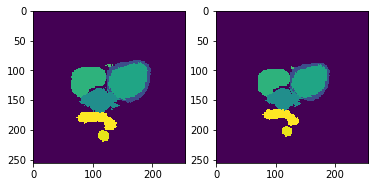

ok
NN
NN
NN


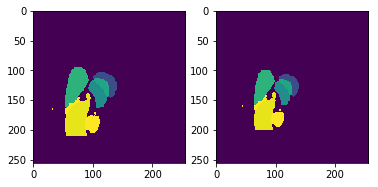

ok
NN
NN
NN


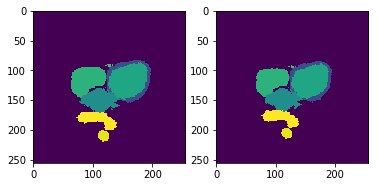

ok
NN
NN
NN


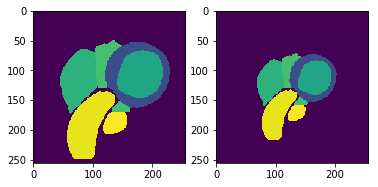

ok
NN
NN
NN


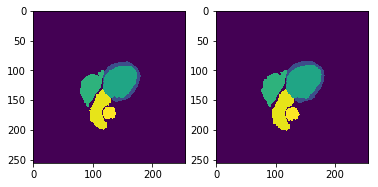

ok
NN
NN
NN


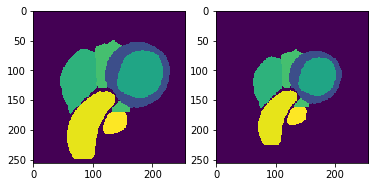

ok
NN
NN
NN


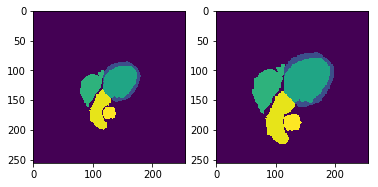

ok
NN
NN
NN


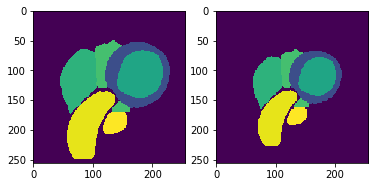

ok
NN
NN
NN


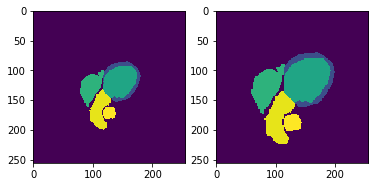

ok
NN
NN
NN


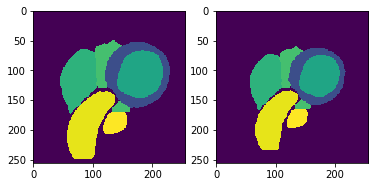

ok
NN
NN
NN


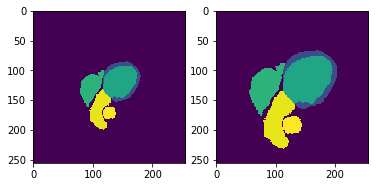

ok
NN
NN
NN


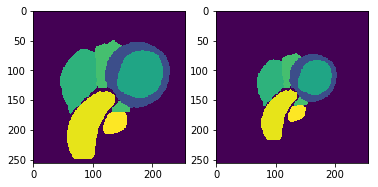

ok
NN
NN
NN


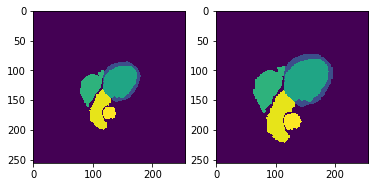

ok
NN
NN
NN


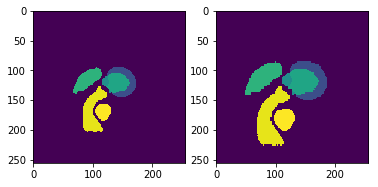

ok
NN
NN
NN


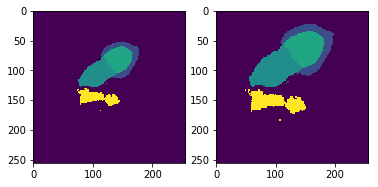

ok
NN
NN
NN


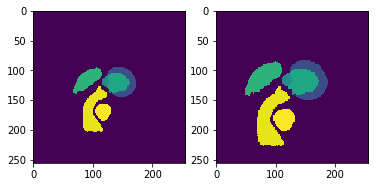

ok
NN
NN
NN


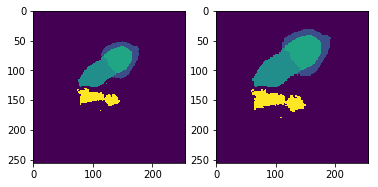

ok
NN
NN
NN


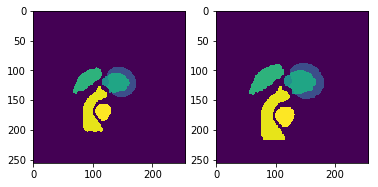

ok
NN
NN
NN


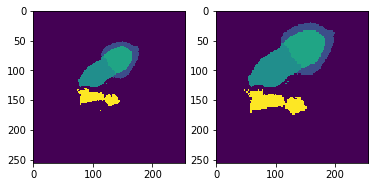

ok
NN
NN
NN


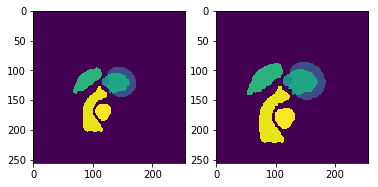

ok
NN
NN
NN


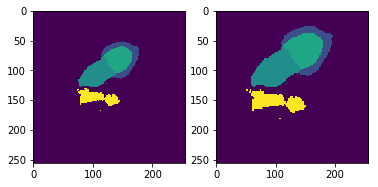

ok
NN
NN
NN


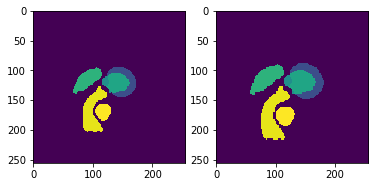

ok
NN
NN
NN


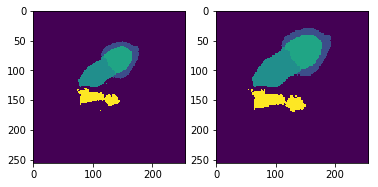

ok
NN
NN
NN


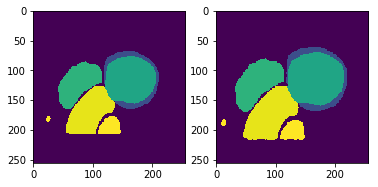

ok
NN
NN
NN


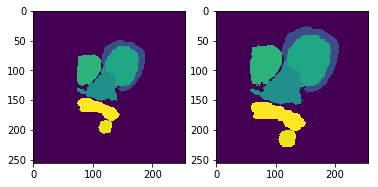

ok
NN
NN
NN


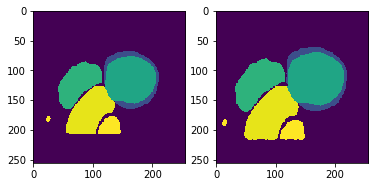

ok
NN
NN
NN


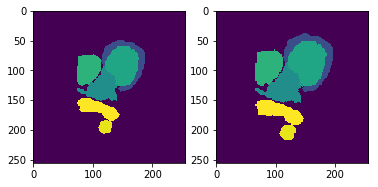

ok
NN
NN
NN


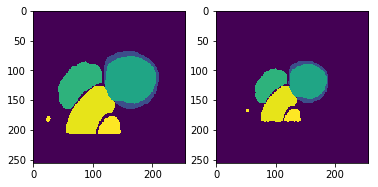

ok
NN
NN
NN


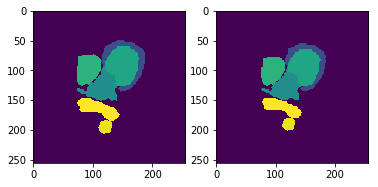

ok
NN
NN
NN


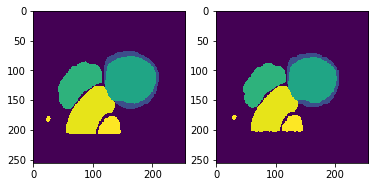

ok
NN
NN
NN


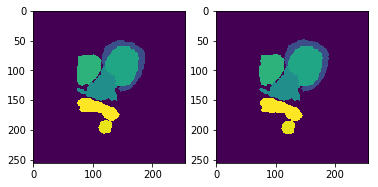

ok
NN
NN
NN


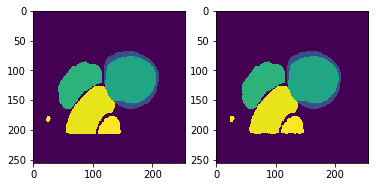

ok
NN
NN
NN


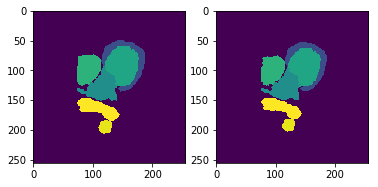

ok
NN
NN
NN


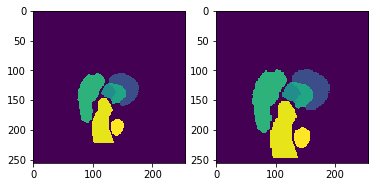

ok
NN
NN
NN


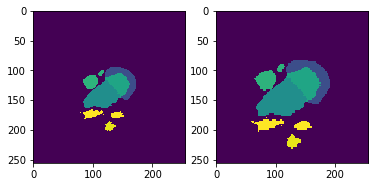

ok
NN
NN
NN


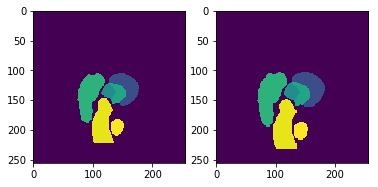

ok
NN
NN
NN


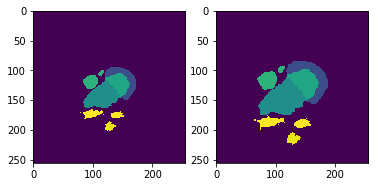

ok
NN
NN
NN


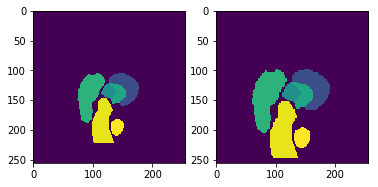

ok
NN
NN
NN


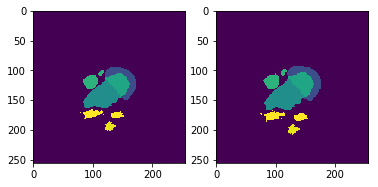

ok
NN
NN
NN


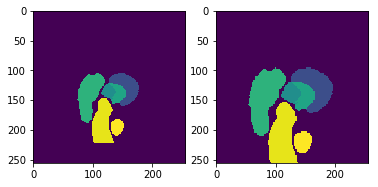

ok
NN
NN
NN


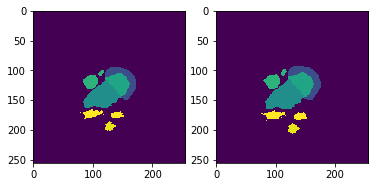

ok
NN
NN
NN


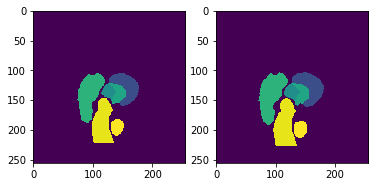

ok
NN
NN
NN


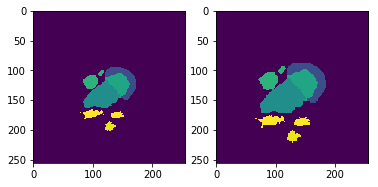

ok
NN
NN
NN


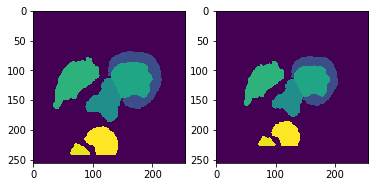

ok
NN
NN
NN


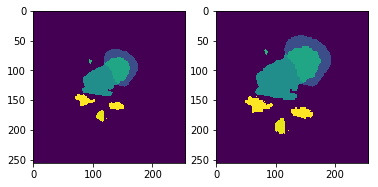

ok
NN
NN
NN


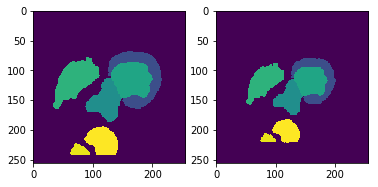

ok
NN
NN
NN


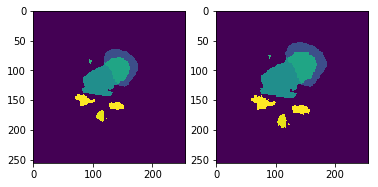

ok
NN
NN
NN


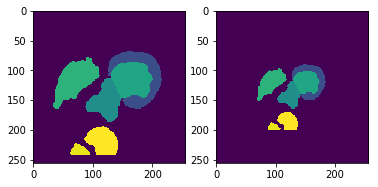

ok
NN
NN
NN


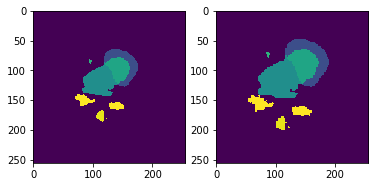

ok
NN
NN
NN


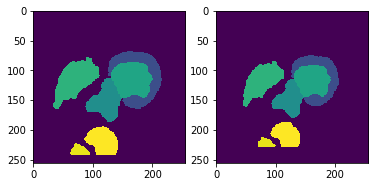

ok
NN
NN
NN


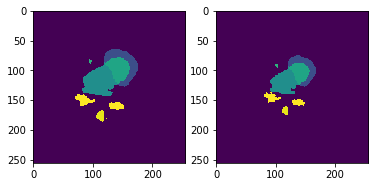

ok
NN
NN
NN


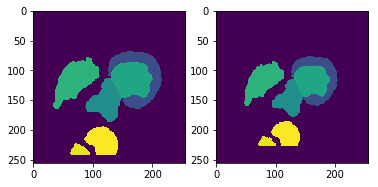

ok
NN
NN
NN


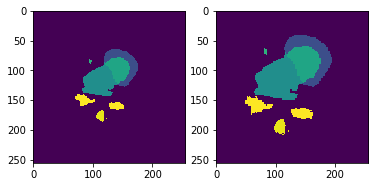

ok


In [20]:
# mask 

outputs_ct = []
outputs_mr = []

num = len(y_train_filenames_ct)
aug_num = 5

def _augment(train_filenames, range_adjust, ratio, order=1):
    scale_factor = np.mean([sample_in_range(range_adjust[0]), sample_in_range(range_adjust[1]), sample_in_range(range_adjust[2])]/ratio)
    sitkIm, ref_img = resample_spacing(train_filenames, order=order)
    image = sitk.GetArrayFromImage(resample_scale(sitkIm, ref_img, scale_factor, order)).astype(np.float64)
    return image


for i in range(num):
    for j in range(aug_num):
        mask_ct = _augment(y_train_filenames_ct[i], range_adjust, ratio_ct[i,:], order=0)
        resized = resize(mask_ct,(64,64,64),order=0)
        outputs_ct.append(resized.flatten())
        mask_mr = _augment(y_train_filenames_mr[i], range_adjust, ratio_mr[i,:], order=0)
        outputs_mr.append(resize(mask_mr,(64,64,64),order=0).flatten())

Computing t-SNE embedding


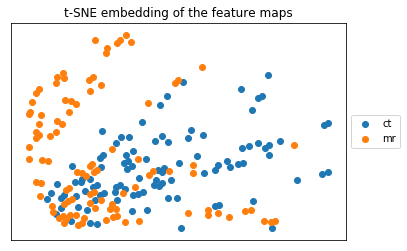

In [23]:
from sklearn import manifold
#----------------------------------------------------------------------
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca')
X_tsne = tsne.fit_transform(np.concatenate((outputs_ct, outputs_mr)))
plot_embedding(X_tsne, np.array([np.zeros(len(outputs_ct)), np.ones(len(outputs_mr))]).flatten(),
               "t-SNE embedding of the feature maps")

plt.show()

In [65]:
print(np.max(outputs_ct))

0.025955596246280615


NameError: ignored

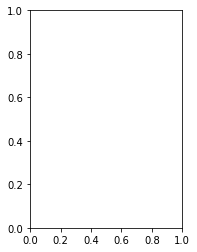

In [0]:
plt.figure()
plt.subplot(1,2,1)
print(np.max(features_ct), np.min(features_ct))
print(np.max(features_mr), np.min(features_mr))
plt.imshow(features_ct[10,:,:], vmax=1000,vmin=0)
plt.subplot(1,2,2)
plt.imshow(features_mr[10,:,:], vmax=1000,vmin=0)
plt.show()